# PARAFAC2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl
import math
from scipy.interpolate import interp1d
from scipy.linalg import pinv
import tlviz
from tensorly.decomposition import parafac2, parafac
from tensorly.parafac2_tensor import parafac2_to_slices
from kneed import KneeLocator
import warnings
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri, pandas2ri, r
from rpy2.robjects.packages import importr
from tensorly import to_numpy
from tensorly.cp_tensor import CPTensor
from tensorly.parafac2_tensor import Parafac2Tensor, apply_parafac2_projections
from tlviz.model_evaluation import core_consistency

## Import tensors

In [2]:
# real data
tensor_real = np.load('real_data/parafac2_data.npy', allow_pickle=True)
# simulated data
tensor_3 = np.load('simulated_data/tensor_3.npy', allow_pickle=True)
tensor_4 = np.load('simulated_data/tensor_4.npy', allow_pickle=True)

In [3]:
real_tensors = [tensor_real]
real_names = ["PARAFAC2 tensor"]
sim_tensors = [tensor_3, tensor_4]
sim_names = ["tensor_3", "tensor_4"]

## Parafac2 matrices to Parafac tensor

In [4]:
def parafac2_to_parafac(slices, rank):
    weights, factors, projections = parafac2(slices, rank=rank, init='svd')

    X_slices = []

    A = factors[0]
    H = factors[1]
    C = factors[2]
    C_T = factors[2].T

    for i in range(len(A)):
        D = np.zeros((rank, rank))
        np.fill_diagonal(D, A[i])
        X = H @ D @ C_T
        X_slices.append(X)

    rec_tensor = np.stack(X_slices, axis=-1)
    new_slices = [projections[i].T @ slices[i] for i in range(len(slices))]
    new_tensor = np.stack(new_slices, axis=-1)

    new_factors = [H, C, A]
    new_weights = np.ones(rank)
    new_model = (new_weights, new_factors)

    return new_tensor, rec_tensor, new_model

## Reconstruction error

In [5]:
def error_parafac2(original_list, parafac2_model):
    res = parafac2_to_slices(parafac2_model)

    assert len(original_list) == len(res)

    numerator = 0
    denominator = 0
    for i in range(len(original_list)):
        assert original_list[i].shape == res[i].shape
        numerator += np.sum((original_list[i] - res[i])**2)
        denominator += np.sum(original_list[i]**2)

    return numerator / denominator

In [6]:
def visualization_error_parafac2(slices, names):
    val = len(slices)
    fig, axes = plt.subplots(1, val, figsize=(val*3, 3))
    if val == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    warnings.simplefilter("ignore", UserWarning)

    for ax, tensor, name in zip(axes, slices, names):
        errors = pd.DataFrame(columns=["Num of Comps.", "Reconstruction error"])
        for rr in np.arange(1, 7):
            model = parafac2(tensor, rank=rr, init='svd')
            err = error_parafac2(tensor, model)
            errors.loc[len(errors)] = [rr, err]
    
        print(errors)
    
        kneedle = KneeLocator(errors["Num of Comps."], errors["Reconstruction error"], curve="convex", direction="decreasing")
        elbow = kneedle.elbow
        
        sns.pointplot(data=errors, x="Num of Comps.", y="Reconstruction error", ax=ax)
        ax.set_title(name)
        ax.set_xticklabels(errors["Num of Comps."].astype(int))
    
        if elbow:
            ax.axvline(elbow - 1, color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

   Num of Comps.  Reconstruction error
0            1.0              0.523102
1            2.0              0.358742
2            3.0              0.274021
3            4.0              0.226845
4            5.0              0.188387
5            6.0              0.161543


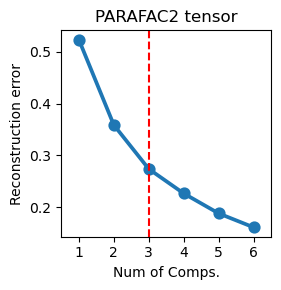

In [7]:
visualization_error_parafac2(real_tensors, real_names)

   Num of Comps.  Reconstruction error
0            1.0              0.617607
1            2.0              0.363118
2            3.0              0.211222
3            4.0              0.193244
4            5.0              0.177044
5            6.0              0.163114
   Num of Comps.  Reconstruction error
0            1.0              0.383482
1            2.0              0.140332
2            3.0              0.132769
3            4.0              0.125576
4            5.0              0.119311
5            6.0              0.113594


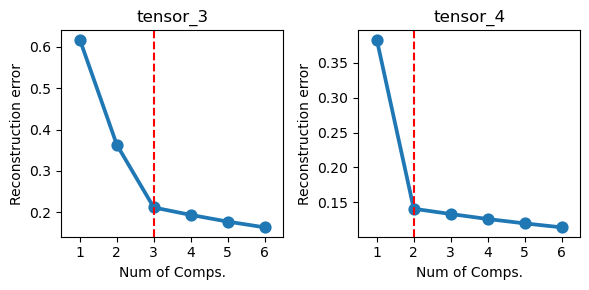

In [8]:
visualization_error_parafac2(sim_tensors, sim_names)

## Core Consistency Diagnostic

In [9]:
def visualization_corcondia(slices, names):
    val = len(slices)
    fig, axes = plt.subplots(1, val, figsize=(val*3, 3))
    if val == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for ax, tensor, name in zip(axes, slices, names):
        corcondia_values = []
        models = {}
        ranks = [1, 2, 3, 4, 5, 6]
        for rank in ranks:
            original, rec_tensor, new_model = parafac2_to_parafac(tensor, rank)
            models[rank] = new_model
            corcondia = core_consistency(new_model, original)
            corcondia_values.append(corcondia)

        ax.plot(ranks, corcondia_values, marker='o')
        ax.set_title(name)
        ax.set_ylim(0, 105)
        ax.set_xlabel("Num of Comps.")
        ax.set_ylabel("Core consistency")
        ax.set_xticks(ranks)

        first = round(corcondia_values[0], 2)
        second = round(corcondia_values[1], 2)
        third = round(corcondia_values[2], 2)
        forth = round(corcondia_values[3], 2)
    
        print(f"Corcondia values for {name}: {first}, {second}, {third}, {forth}")
        
    plt.tight_layout()
    plt.show()

Corcondia values for PARAFAC2 tensor: 100.0, 100.0, 98.38, 49.11


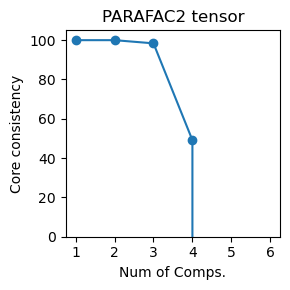

In [10]:
visualization_corcondia(real_tensors, real_names)

Corcondia values for tensor_3: 100.0, 100.0, 99.98, 95.89
Corcondia values for tensor_4: 100.0, 100.0, 99.96, 89.23


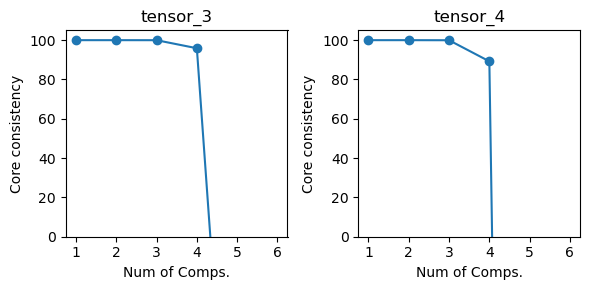

In [11]:
visualization_corcondia(sim_tensors, sim_names)

## PARAFAC2 Decomposition

In [12]:
def decomposition_visualization(factors, patients):
    factor_labels = ["T Cells", "Days", "Patients"]
    num_components = factors[0].shape[1]
    
    num_patients = len(patients)
    colors = sns.color_palette("tab20", n_colors=num_patients)

    fig, axes = plt.subplots(num_components, 3, figsize=(16, 4 * num_components))

    for component in range(num_components):
        for dim in range(3):
            ax = axes[component, dim] if num_components > 1 else axes[dim]
            ax.set_title(f"Component {component + 1} - {factor_labels[dim]}")
            ax.set_xlabel(factor_labels[dim])
            ax.set_ylabel("Weight")

            if dim == 0:
                ax.bar(range(factors[2].shape[0]), factors[2][:, component], color='royalblue', alpha=0.8)

            elif dim == 1:
                for i, matrix in enumerate(factors[1]):
                    patient_weight = factors[0][i, component]
                    threshold = 0.5 * np.max(factors[0][:, component])
                    if abs(patient_weight) >= threshold:
                        time_points = np.arange(matrix.shape[0])
                        ax.plot(10*time_points, matrix[:, component], label=patients[i], color=colors[i], alpha=0.8)

            elif dim == 2:
                ax.bar(range(num_patients), factors[0][:, component], color=colors, alpha=0.8)
                ax.axhline(threshold, color='red', linestyle='--', linewidth=1.5, label='Threshold')
                ax.axhline(-threshold, color='red', linestyle='--', linewidth=1.5, label='Threshold')
                ax.set_xticks(range(num_patients))
                ax.set_xticklabels(patients, rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

### Real data

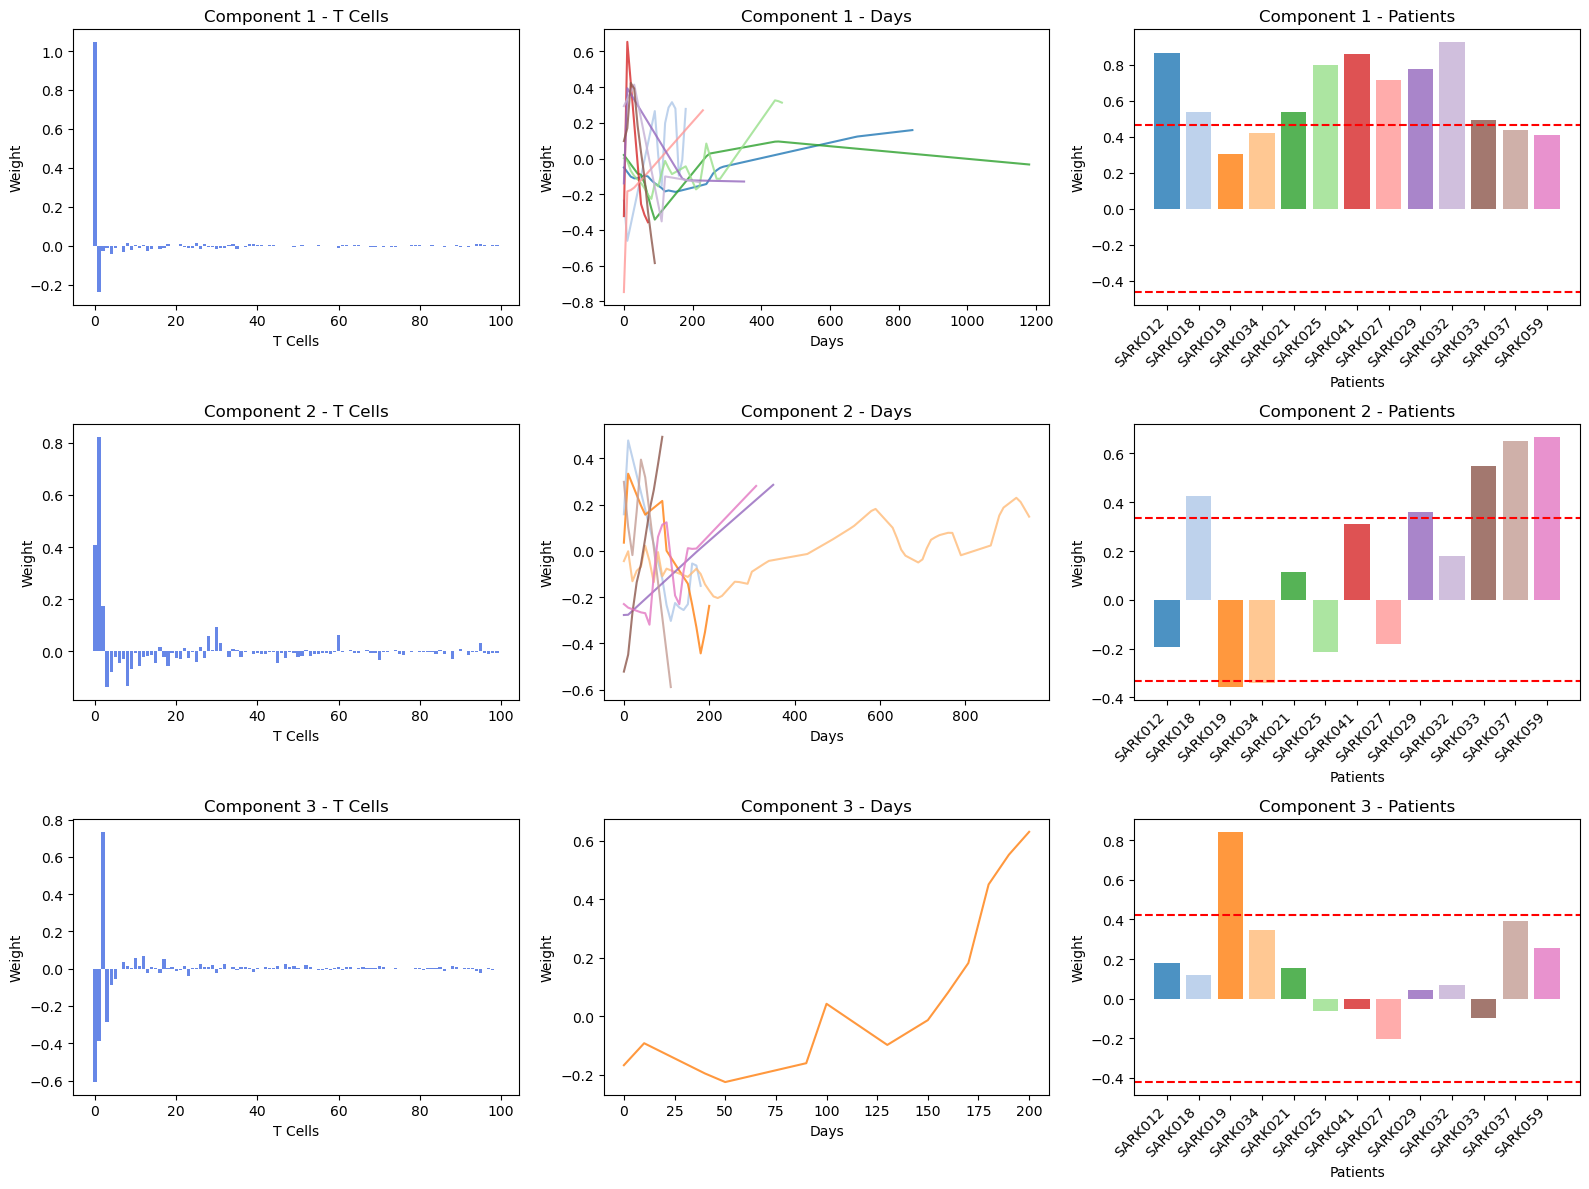

In [13]:
model = parafac2(tensor_real, rank=3, init='svd')
parafac2_weights, parafac2_factors = apply_parafac2_projections(model)

patients = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']

decomposition_visualization(parafac2_factors, patients)

### Simulated data

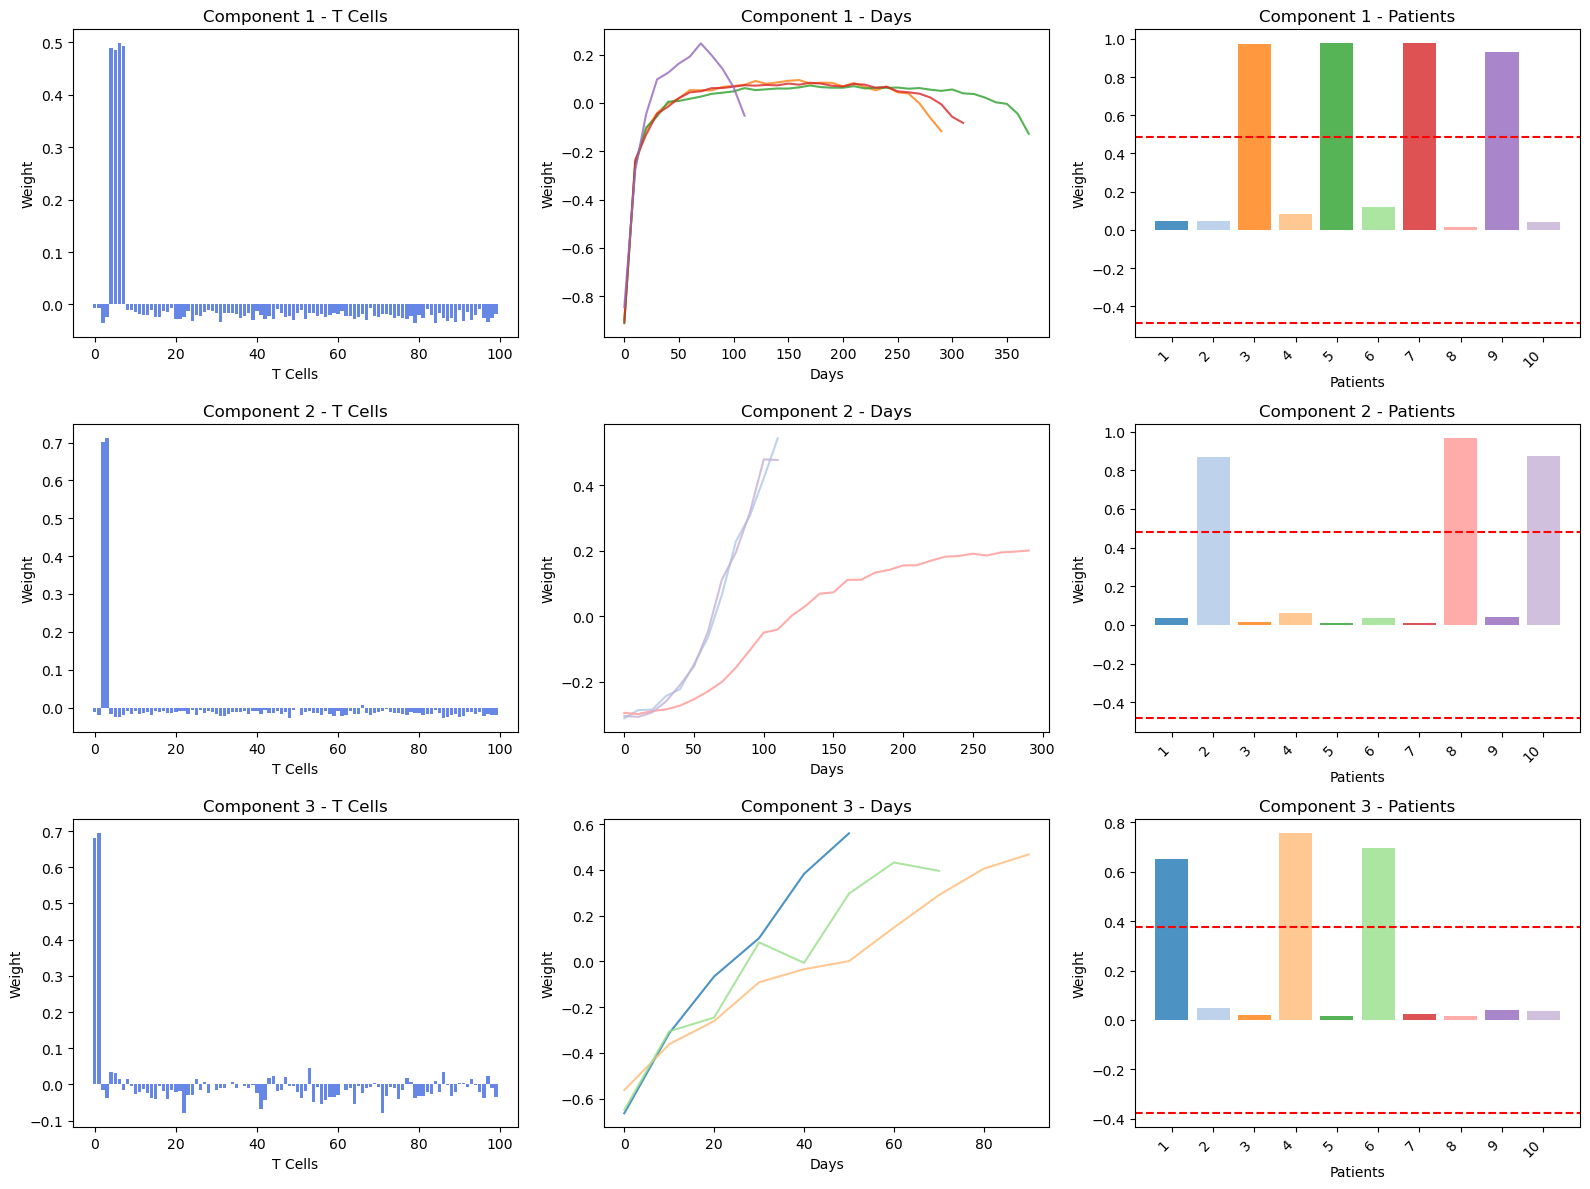

In [14]:
model_3 = parafac2(tensor_3, rank=3, init='svd')
parafac2_weights_3, parafac2_factors_3 = apply_parafac2_projections(model_3)

patients = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

decomposition_visualization(parafac2_factors_3, patients)

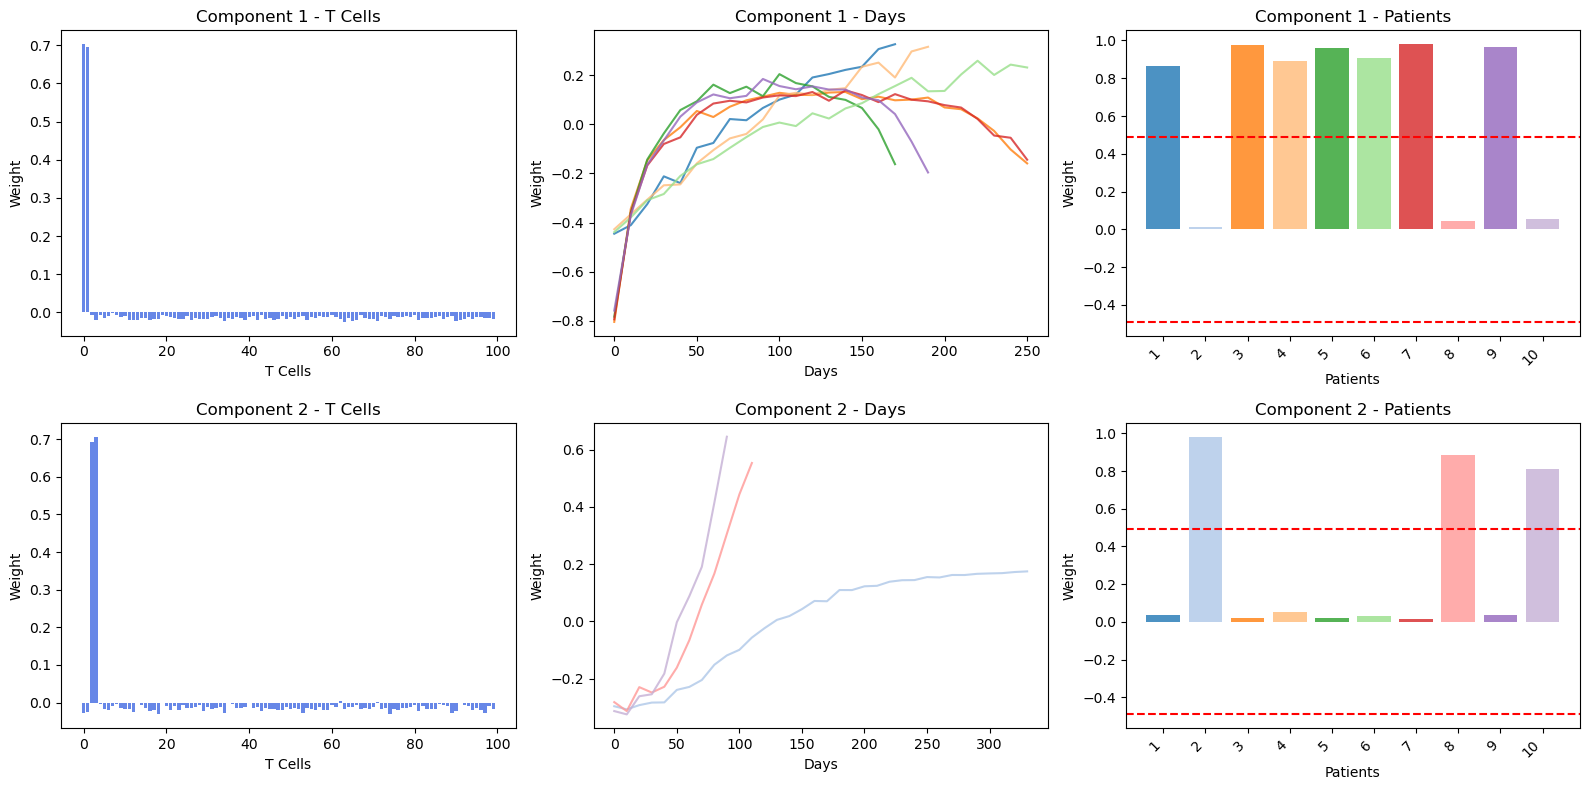

In [15]:
model_4 = parafac2(tensor_4, rank=2, init='svd')
parafac2_weights_4, parafac2_factors_4 = apply_parafac2_projections(model_4)

patients = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

decomposition_visualization(parafac2_factors_4, patients)